In [27]:
import torch
from sentence_transformers.cross_encoder import CrossEncoder
from sentence_transformers.cross_encoder.evaluation import CESoftmaxAccuracyEvaluator
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sentence_transformers.readers import InputExample
from tqdm import tqdm
from transformers import AdamW, get_scheduler, AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import f1_score, accuracy_score
import sys
import os
import pandas as pd
import dask.dataframe as dd
from huggingface_hub import login
sys.path.append(os.path.abspath('..'))
from config import TOKEN_1
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from torch.cuda.amp import autocast

In [61]:
examples_path = os.path.join('..', 'data', 'shopping_queries_dataset_examples.parquet')
products_path = os.path.join('..', 'data', 'shopping_queries_dataset_products.parquet')
sources_path = os.path.join('..', 'data', 'shopping_queries_dataset_sources.csv')

examples = dd.read_parquet(examples_path)
products = dd.read_parquet(products_path)
sources = dd.read_csv(sources_path)

In [62]:
examples_products = dd.merge(
    examples,
    products,
    how='left',
    left_on=['product_locale','product_id'],
    right_on=['product_locale', 'product_id']
)

examples_products = examples_products[examples_products['product_locale'] == 'us']

task_2 = examples_products[examples_products['large_version'] == 1]

label_mapping = {'E': 0, 
                 'S': 1, 
                 'C': 2, 
                 'I': 3}

task_2['encoded_labels'] = task_2['esci_label'].map(label_mapping).astype(int)

task_2_train = task_2[task_2['split'] == 'train']
task_2_test = task_2[task_2['split'] == 'test']

/home/sllawlis/python3.14/lib/python3.11/site-packages/dask_expr/_collection.py:4196: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('esci_label', 'float64'))

  warnings.warn(meta_warning(meta))


In [4]:
task_2_train = task_2_train.compute()
task_2_test = task_2_test.compute()

In [5]:
# total_rows = task_2_train.shape[0].compute()

# sample_fraction = 10000 / total_rows

# task_2_train_sample = task_2_train.sample(frac=sample_fraction, random_state=21)

# task_2_train_sample = task_2_train_sample.compute()

In [6]:
# total_rows2 = task_2_test.shape[0].compute()

# sample_fraction2 = 10000 / total_rows2

# task_2_test_sample = task_2_test.sample(frac=sample_fraction2, random_state=21)

# task_2_test_sample = task_2_test_sample.compute()

In [7]:
def collate_fn(batch):
    # Extract texts and labels from InputExample objects
    texts = [(example.texts[0], example.texts[1]) for example in batch]
    labels = [example.label for example in batch]
    return {"texts": texts, "labels": labels}

In [8]:
def prepare_data(dataset):
    samples = []
    for _, row in dataset.iterrows():
        query = row["query"]
        product = row["product_title"]
        label = int(row["encoded_labels"])
        samples.append(InputExample(texts=[query, product], label=label))
    return samples

train_samples, dev_samples = train_test_split(task_2_train, test_size=0.1, random_state=21)
train_samples = prepare_data(train_samples)
dev_samples = prepare_data(dev_samples)

batch_size = 32
train_dataloader = DataLoader(train_samples, shuffle=True, batch_size=batch_size, collate_fn=collate_fn)
dev_dataloader = DataLoader(dev_samples, shuffle=False, batch_size=batch_size, collate_fn=collate_fn)

In [9]:
model_name = "sentence-transformers/all-distilroberta-v1"
model = CrossEncoder(model_name, num_labels=4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.model.to(device)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/all-distilroberta-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-5): 6 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
           

In [10]:
print(device)

cuda


In [11]:
print(torch.cuda.get_device_name(0))

Tesla V100-PCIE-32GB


In [12]:
optimizer = AdamW(model.model.parameters(), lr=5e-5)
num_training_steps = len(train_dataloader) * 3  # 3 epochs
scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=int(0.1 * num_training_steps), num_training_steps=num_training_steps)

# Loss Function
loss_fn = torch.nn.CrossEntropyLoss()

/home/sllawlis/python3.14/lib/python3.11/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [13]:
epochs = 3

for epoch in range(epochs):
    model.model.train()
    total_loss = 0

    with tqdm(total=len(train_dataloader), desc=f"Epoch {epoch + 1}/{epochs}", unit="batch") as progress_bar:
        for batch in train_dataloader:
            sentences = batch["texts"]
            labels = torch.tensor(batch["labels"], dtype=torch.long).to(device)

            inputs = model.tokenizer(
                [pair[0] for pair in sentences],  # Query
                [pair[1] for pair in sentences],  # Product Title
                truncation=True,
                padding=True,
                max_length=512,
                return_tensors="pt",
            ).to(device)

            # forward pass
            outputs = model.model(**inputs)
            logits = outputs.logits

            # compute loss
            loss = loss_fn(logits, labels)
            total_loss += loss.item()

            # backward pass + optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()

            # update progress bar
            progress_bar.update(1)
            progress_bar.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch + 1} - Average Loss: {avg_loss:.4f}")

    # validation
    model.model.eval()
    all_preds, all_labels = [], []

    # validation Loop
    with torch.no_grad():
        with tqdm(total=len(dev_dataloader), desc="Evaluating", unit="batch") as progress_bar:
            for batch in dev_dataloader:
                sentences = batch["texts"]
                labels = torch.tensor(batch["labels"], dtype=torch.long).to(device)

                # tokenize sentences
                inputs = model.tokenizer(
                    [pair[0] for pair in sentences],
                    [pair[1] for pair in sentences],
                    truncation=True,
                    padding=True,
                    max_length=128,
                    return_tensors="pt",
                ).to(device)

                # forward pass
                outputs = model.model(**inputs)
                logits = outputs.logits
                predictions = torch.argmax(logits, dim=1)

                # collect predictions and labels
                all_preds.extend(predictions.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

                progress_bar.update(1)

    # compute metrics
    f1 = f1_score(all_labels, all_preds, average="micro")
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Epoch {epoch + 1} - Validation F1: {f1:.4f}, Accuracy: {accuracy:.4f}")

Epoch 1/3: 100%|██████████| 39180/39180 [45:40<00:00, 14.30batch/s, loss=0.606]


Epoch 1 - Average Loss: 0.6130


Evaluating: 100%|██████████| 4354/4354 [01:33<00:00, 46.38batch/s]


Epoch 1 - Validation F1: 0.8023, Accuracy: 0.8023


Epoch 2/3: 100%|██████████| 39180/39180 [45:31<00:00, 14.35batch/s, loss=0.324] 


Epoch 2 - Average Loss: 0.4713


Evaluating: 100%|██████████| 4354/4354 [01:32<00:00, 46.95batch/s]


Epoch 2 - Validation F1: 0.8371, Accuracy: 0.8371


Epoch 3/3: 100%|██████████| 39180/39180 [45:30<00:00, 14.35batch/s, loss=0.328] 


Epoch 3 - Average Loss: 0.3827


Evaluating: 100%|██████████| 4354/4354 [01:32<00:00, 46.94batch/s]


Epoch 3 - Validation F1: 0.8465, Accuracy: 0.8465


In [14]:
output_dir = "trained_crossencoder_model"
model.save(output_dir)

In [7]:
login(token=TOKEN_1)

In [16]:
tokenizer = AutoTokenizer.from_pretrained(output_dir)
trained_model = AutoModelForSequenceClassification.from_pretrained(output_dir)

In [17]:
repo_name = "sllawlis/distilroberta-ce-esci"
trained_model.push_to_hub(repo_name)
tokenizer.push_to_hub(repo_name)

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/sllawlis/distilroberta-ce-esci/commit/991b73f1bba0d7f3e1bc9d503e57e63f2fbce6aa', commit_message='Upload tokenizer', commit_description='', oid='991b73f1bba0d7f3e1bc9d503e57e63f2fbce6aa', pr_url=None, repo_url=RepoUrl('https://huggingface.co/sllawlis/distilroberta-ce-esci', endpoint='https://huggingface.co', repo_type='model', repo_id='sllawlis/distilroberta-ce-esci'), pr_revision=None, pr_num=None)

In [63]:
total_rows2 = task_2_test.shape[0].compute()

sample_fraction2 = 1000 / total_rows2

task_2_test_sample = task_2_test.sample(frac=sample_fraction2, random_state=21)

task_2_test_sample = task_2_test_sample.compute()

In [64]:
def collate_fn(batch):
    # Transpose the batch to convert from ([queries], [products]) to [(query, product), ...]
    queries, products = batch
    return list(zip(queries, products))

In [65]:
torch.cuda.empty_cache()

In [66]:
tokenizer = AutoTokenizer.from_pretrained("sllawlis/distilroberta-ce-esci")
model = AutoModelForSequenceClassification.from_pretrained("sllawlis/distilroberta-ce-esci")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

query_product_pairs = list(zip(
    task_2_test_sample["query"].tolist(),
    task_2_test_sample["product_title"].tolist()
))
actual_labels = task_2_test_sample["encoded_labels"].tolist()

model.gradient_checkpointing_enable()

batch_size = 8
dataloader = torch.utils.data.DataLoader(
    list(zip(*query_product_pairs)),
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn
)

# predictions
predicted_classes = []
model.eval()

with torch.no_grad():
    for batch in tqdm(dataloader, desc="Predicting"):
        batch_queries, batch_products = zip(*batch)
        inputs = tokenizer(
            list(batch_queries),
            list(batch_products),
            truncation=True,
            padding=True,
            max_length=256,
            return_tensors="pt"
        ).to(device)

        with autocast():
            outputs = model(**inputs)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=1).tolist()
            predicted_classes.extend(predictions)
        
        torch.cuda.empty_cache()

label_mapping = {0: "E", 1: "S", 2: "C", 3: "I"}

print("Classification Report:")
print(classification_report(
    actual_labels,  # True labels
    predicted_classes,  # Predicted labels
    target_names=[label_mapping[i] for i in range(len(label_mapping))]
))

micro_f1 = f1_score(actual_labels, predicted_classes, average="micro")
print(f"\nMicro F1 Score: {micro_f1:.4f}")

Predicting:   0%|          | 0/1 [00:00<?, ?it/s]/tmp/ipykernel_214309/4072296436.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Predicting: 100%|██████████| 1/1 [00:00<00:00,  4.24it/s]

Classification Report:
              precision    recall  f1-score   support

           E       0.82      0.89      0.85       649
           S       0.52      0.48      0.50       209
           C       0.55      0.38      0.44        32
           I       0.53      0.38      0.44       110

    accuracy                           0.73      1000
   macro avg       0.60      0.53      0.56      1000
weighted avg       0.72      0.73      0.72      1000


Micro F1 Score: 0.7330


In [69]:
output_df = pd.DataFrame({
    "query": [pair[0] for pair in query_product_pairs],
    "product_title": [pair[1] for pair in query_product_pairs],
    "actual_label": actual_labels,
    "predicted_label": predicted_classes
})

output_file = "/home/sllawlis/esci-shopping-queries/data/distilbert-ce-esci-test1.csv"
output_df.to_csv(output_file, index=False)
print(f"Predictions saved to {output_file}")

Predictions saved to /home/sllawlis/esci-shopping-queries/data/distilbert-ce-esci-test1.csv


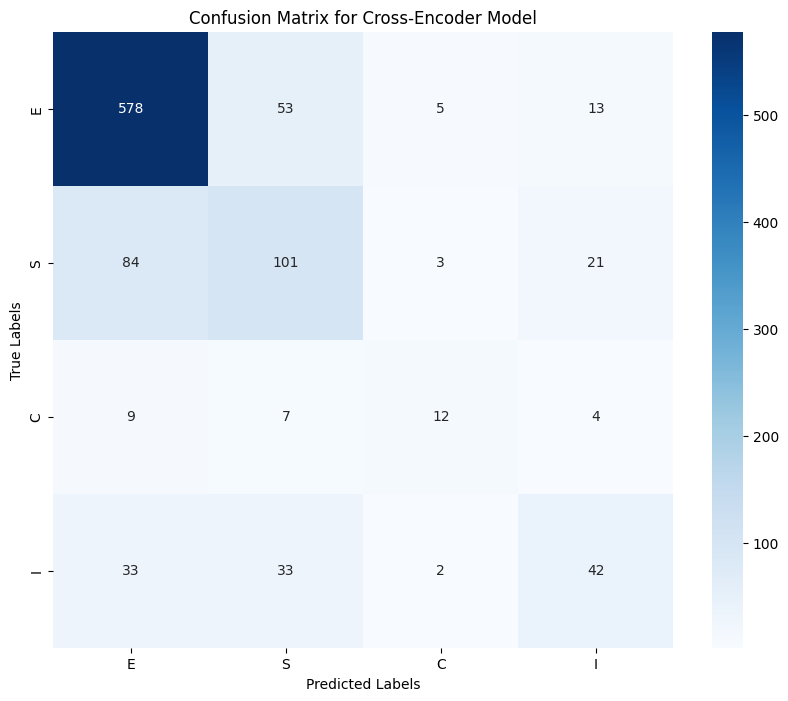

In [67]:
true_labels = actual_labels  # From the dataset (e.g., `task_2_test_sample`)
predicted_labels = predicted_classes  # From the predictions

# Create the confusion matrix
fig, ax = plt.subplots(figsize=(10, 8))
cm = confusion_matrix(true_labels, predicted_labels)

# Define label mapping (ensure it matches the training labels)
label_mapping = {0: "E", 1: "S", 2: "C", 3: "I"}
class_names = [label_mapping[i] for i in range(len(label_mapping))]

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Cross-Encoder Model')
plt.show()